In [2]:
import pandas as pd
import numpy as np
import os
import ipywidgets as widgets
from IPython.display import display
import matplotlib.pyplot as plt


This is the method for .dat files from Qizix Pump


In [3]:

# removes unecessary rows from .dat file; header and footer 
# ==========================================
# 1. TRIM FUNCTION (Updated)
# ==========================================
def trim_dat_file(input_file, output_folder, skip_top=6, skip_bottom=8):
    """
    Removes the first `skip_top` rows and last `skip_bottom` rows from a .dat file.
    Output file is automatically named: <input_filename>-trimmed.dat
    Saved in the specified `output_folder`.
    """
    # --- Generate Output Path Automatically ---
    # Split the input path into folder, filename, and extension
    _, filename = os.path.split(input_file)
    name, ext = os.path.splitext(filename)
    
    # Create new filename: "InputName-trimmed.dat"
    output_filename = f"{name}-trimmed{ext}"
    
    # Ensure output folder exists
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
        print(f"📂 Created new output folder: {output_folder}")

    output_file = os.path.join(output_folder, output_filename)

    # --- Process File ---
    try:
        with open(input_file, "r") as f:
            lines = f.readlines()
        
        # Keep only the middle part
        # Ensure we don't try to slice if file is too short
        if len(lines) > (skip_top + skip_bottom):
            trimmed_lines = lines[skip_top : len(lines) - skip_bottom]
            
            with open(output_file, "w") as f:
                f.writelines(trimmed_lines)
                
            print(f"✂️  Trimmed file saved: {output_filename}")
            print(f"   Location: {output_file}")
            return output_file
        else:
            print(f"❌ Error: File has fewer lines ({len(lines)}) than the skip count.")
            return None
    except FileNotFoundError:
        print(f"❌ Error: Input file not found at {input_file}")
        return None
    



    # Create Widgets
style = {'description_width': '120px'}
layout_full = widgets.Layout(width='90%')

w_input_path = widgets.Text(
    value='/Users/adaciortan/Desktop/experiment data/daca ai fii un stick/2025-07-01_h2-100bar_SRB.dat',
    placeholder='Path to .dat file',
    description='<b>Input File Path:</b>',
    style=style, layout=layout_full
)

w_output_folder = widgets.Text(
    value='/Users/adaciortan/Desktop/experiment data/daca ai fii un stick/trimmed output',
    placeholder='Path to save trimmed file',
    description='<b>Output Folder:</b>',
    style=style, layout=layout_full
)

w_skip_top = widgets.IntText(value=6, description='Skip Top Rows:', style=style)
w_skip_bottom = widgets.IntText(value=8, description='Skip Bottom Rows:', style=style)

w_btn_defaults = widgets.Button(
    description='Stick to Original (6, 8)',
    button_style='info',
    icon='undo'
)

w_btn_run = widgets.Button(
    description='Run Trim Only',
    button_style='success',
    icon='cut',
    layout=widgets.Layout(width='100%', margin='20px 0px 0px 0px')
)

w_out = widgets.Output()

# Event Handlers
def set_defaults(b):
    w_skip_top.value = 6
    w_skip_bottom.value = 8
    with w_out:
        print("Settings reset to defaults: Top=6, Bottom=8")

def on_run_click(b):
    w_out.clear_output()
    with w_out:
        print("⏳ Processing...")
        # Run Trim
        trim_dat_file(
            input_file=w_input_path.value,
            output_folder=w_output_folder.value,
            skip_top=w_skip_top.value,
            skip_bottom=w_skip_bottom.value
        )
        print("Done.")

# Bind events
w_btn_defaults.on_click(set_defaults)
w_btn_run.on_click(on_run_click)

# Display UI
ui = widgets.VBox([
    widgets.HTML("<h3>✂️ Data Trimmer (Phase 1)</h3>"),
    w_input_path,
    w_output_folder,
    widgets.HBox([w_skip_top, w_skip_bottom, w_btn_defaults]),
    w_btn_run,
    w_out
])

display(ui)


In [4]:
def extract_time_and_volume(input_path: str, output_path: str, output_folder: str):
    """
    Extracts time and volume columns.
    Uses the input filename (removing '-trimmed') as the prefix.
    Saves .npy arrays named like: <filename>-time.npy
    """
    
    filename = os.path.basename(input_path)
    name_without_ext = os.path.splitext(filename)[0]
    
    # Use the full name as prefix, removing '-trimmed' if present
    file_prefix = name_without_ext.replace("-trimmed", "")
    
    print(f"Detected prefix for naming: {file_prefix}")

    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
        print(f"Created new folder: {output_folder}")

    try:
        df = pd.read_csv(
            input_path,
            header=None,
            usecols=[2, 11, 12], #2, 8, 10 2, 11, 12
            delimiter=",",
            engine="python"
        )
    except Exception as e:
        print(f"❌ Error reading CSV: {e}")
        return None

    df.columns = ["cum_min_200", "c_vol1_200", "c_vol2_200"]

    for col in df.columns:
        df[col] = pd.to_numeric(df[col], errors="coerce")
    df = df.dropna(subset=df.columns)

    # Ensure output directory for the .dat file exists
    dat_folder = os.path.dirname(output_path)
    if dat_folder and not os.path.exists(dat_folder):
        os.makedirs(dat_folder)

    df.to_csv(output_path, index=False, header=False, float_format="%.6f")

    # Construct filenames using the full prefix
    name_time = f"{file_prefix}-time.npy"
    name_vol1 = f"{file_prefix}-volume_1.npy"
    name_vol2 = f"{file_prefix}-volume_2.npy"

    np.save(os.path.join(output_folder, name_time), df["cum_min_200"].to_numpy())
    np.save(os.path.join(output_folder, name_vol1), df["c_vol1_200"].to_numpy())
    np.save(os.path.join(output_folder, name_vol2), df["c_vol2_200"].to_numpy())

    print(f"✅ Arrays saved successfully in: {output_folder}")
    print(f"   Files: {name_time}, {name_vol1}, {name_vol2}")

    return {
        "time":     df["cum_min_200"].to_numpy(),
        "volume_1": df["c_vol1_200"].to_numpy(),
        "volume_2": df["c_vol2_200"].to_numpy(), 
    }


# ==========================================
# 👇 WIDGET 2: EXTRACTOR
# ==========================================

# --- Extract Inputs ---
w_ex_input = widgets.Text(
    value='/Users/adaciortan/Desktop/experiment data/daca ai fii un stick/trimmed output/2025-07-01_h2-100bar_SRB-trimmed.dat',
    placeholder='Path to trimmed .dat file',
    description='<b>Input File:</b>',
    style=style, layout=layout_full
)

w_ex_output_dat = widgets.Text(
    value='/Users/adaciortan/Desktop/experiment data/daca ai fii un stick/trimmed output/2025-07-01_h2-100bar_SRB-final_reduced.dat',
    placeholder='Path for the reduced .dat output',
    description='<b>Output .dat Path:</b>',
    style=style, layout=layout_full
)

w_ex_folder = widgets.Text(
    value='/Users/adaciortan/Desktop/experiment data/daca ai fii un stick/the column',
    placeholder='Folder to save .npy arrays',
    description='<b>Arrays Folder:</b>',
    style=style, layout=layout_full
)

w_btn_extract = widgets.Button(
    description='Run Extraction',
    button_style='warning', # Orange color to distinguish
    icon='download',
    layout=widgets.Layout(width='100%', margin='20px 0 0 0')
)

w_out_extract = widgets.Output()

# --- Auto-Update Output Name ---
# This ensures that if you change the input file, the output name updates automatically
def update_ex_output_path(change):
    path = change['new']
    if path:
        folder, filename = os.path.split(path)
        name, ext = os.path.splitext(filename)
        # Remove '-trimmed' if present to get the clean base
        base_name = name.replace('-trimmed', '')
        # Create new name with -final_reduced
        new_filename = f"{base_name}-final_reduced.dat"
        w_ex_output_dat.value = os.path.join(folder, new_filename)

w_ex_input.observe(update_ex_output_path, names='value')

# --- Extract Logic ---
def on_extract_click(b):
    w_out_extract.clear_output()
    with w_out_extract:
        print("⏳ Extracting arrays...")
        try:
            extract_time_and_volume(
                input_path=w_ex_input.value,
                output_path=w_ex_output_dat.value,
                output_folder=w_ex_folder.value
            )
            print("Done.")
        except Exception as e:
            print(f"❌ Error: {e}")

w_btn_extract.on_click(on_extract_click)

ui_extract = widgets.VBox([
    widgets.HTML("<h3>🧪 Phase 2: Data Extractor</h3>"),
    w_ex_input,
    w_ex_output_dat,
    w_ex_folder,
    w_btn_extract,
    w_out_extract
])

# ==========================================
# DISPLAY ALL
# ==========================================

display(ui_extract)

In [ ]:

# Load arrays from the saved .npy files
time = np.load("/Users/adaciortan/Desktop/experiment data/daca ai fii un stick/the column/2025-07-01_h2-100bar_SRB-time.npy")
volume_1 = np.load("/Users/adaciortan/Desktop/experiment data/daca ai fii un stick/the column/2025-07-01_h2-100bar_SRB-volume_1.npy")
volume_2 = np.load("/Users/adaciortan/Desktop/experiment data/daca ai fii un stick/the column/2025-07-01_h2-100bar_SRB-volume_2.npy")



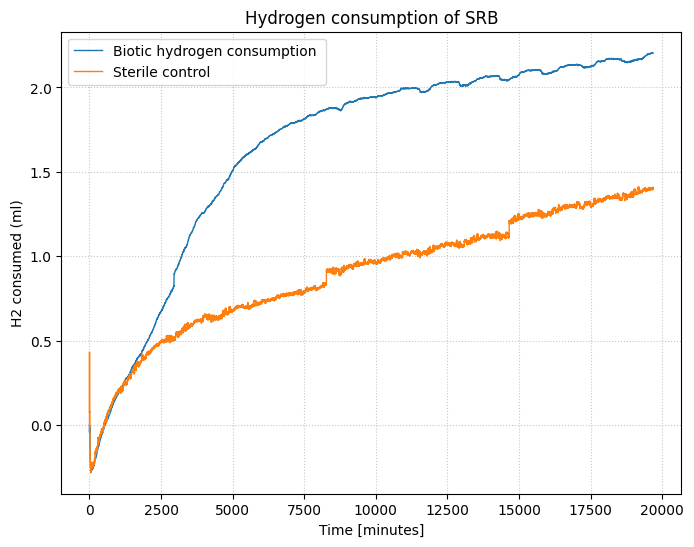

In [6]:
#WITH VOLUME

plt.figure(figsize=(8,6))
plt.plot(time, volume_1, label="Biotic hydrogen consumption ", linewidth=1)
plt.plot(time, volume_2, label="Sterile control ", linewidth=1,)

# Labels and legend
plt.xlabel("Time [minutes]")
plt.ylabel("H2 consumed (ml)")
plt.title("Hydrogen consumption of SRB")
plt.legend()
plt.grid(True, linestyle=":", alpha=0.7)

# Show the plot
plt.show()

Dealing with .csv files (vindum pumps)

First there are two functions for splitting the csv, in case the cylinders of the pumps were switched mid experiment to monitor leak in pumps. The first function has as input the exact date and time when the switch happened. The second function splits the data using the index of when it was switched. 

In [7]:
import pandas as pd

def split_csv_by_datetime(file_path, split_date, split_time):
    # 1. Load the CSV
    df = pd.read_csv(file_path, sep=';', decimal=',', index_col=False)

    # 2. Combine Date and Time columns into a temporary datetime column
    # Adjust 'Date' and 'Time' to match your actual column names
    df['temp_dt'] = pd.to_datetime(df['Date'] + ' ' + df['Time'], format='%d-%m-%Y %H:%M:%S')

    # 3. Create the split point timestamp from your input
    split_point = pd.to_datetime(f"{split_date} {split_time}", format='%d-%m-%Y %H:%M:%S')

    # 4. Split the data
    before_df = df[df['temp_dt'] < split_point]
    after_df = df[df['temp_dt'] >= split_point]

    # 5. Remove the temporary helper column before saving
    before_df = before_df.drop(columns=['temp_dt'])
    after_df = after_df.drop(columns=['temp_dt'])

    # 6. Save the results
    before_df.to_csv('data_before_split.csv', index=False)
    after_df.to_csv('data_after_split.csv', index=False)

    print(f"Split complete! 'Before' rows: {len(before_df)}, 'After' rows: {len(after_df)}")

# Example Usage:
split_csv_by_datetime('/Users/adaciortan/Desktop/leak test/2026-01-13_h2-400bar_SRB.csv', '22-1-2026', '13:40:00')

Split complete! 'Before' rows: 13042, 'After' rows: 5662


In [ ]:
import pandas as pd

def split_csv_by_index(file_path, split_index):
    # 1. Load the CSV
    # Keeping your original settings: semicolon separator and comma decimal
    df = pd.read_csv(file_path, sep=';', decimal=',', index_col=False)

    # 2. Split the data using integer slicing
    # .iloc[:n] takes everything up to index n (exclusive)
    # .iloc[n:] takes everything from index n to the end
    before_df = df.iloc[:split_index]
    after_df = df.iloc[split_index:]

    # 3. Save the results
    before_df.to_csv('data_before_split.csv', index=False)
    after_df.to_csv('data_after_split.csv', index=False)

    print(f"Split complete at index {split_index}!")
    print(f"'Before' rows: {len(before_df)}, 'After' rows: {len(after_df)}")

# Example Usage:
# If you want to cut at row 9980:
split_csv_by_index('/Users/adaciortan/Desktop/experiment data/daca ai fii un stick/2026-01-29_h2-400bar_SRB.csv', 9980)

This function is for trimming csv files in case of unwanted data at the beggining or ends of experiments

In [ ]:
import pandas as pd

def trim_csv(input_path, output_path, trim_start=0, trim_end=0, use_percentage=True):
    """
    Reads a CSV, removes rows from the beginning and end, and saves to a new CSV.
    
    Parameters:
    - input_path: Path to your raw CSV file.
    - output_path: Where you want to save the cleaned data.
    - trim_start: How much to remove from the top.
    - trim_end: How much to remove from the bottom.
    - use_percentage: If True, treats trim values as decimals (e.g., 0.05 for 5%).
                      If False, treats trim values as number of rows.
    """
    # Load the data
    df = pd.read_csv(input_path)
    n = len(df)
    
    # Calculate indices
    if use_percentage:
        start_idx = int(n * trim_start)
        end_idx = n - int(n * trim_end)
    else:
        start_idx = int(trim_start)
        end_idx = n - int(trim_end)
        
    # Trim the data
    # .iloc[start:end] slices rows by index position
    df_trimmed = df.iloc[start_idx:end_idx].reset_index(drop=True)
    
    # Save the output
    df_trimmed.to_csv(output_path, index=False)
    
    print(f"Original rows: {n}")
    print(f"Rows removed: {n - len(df_trimmed)}")
    print(f"Cleaned file saved to: {output_path}")

# --- EXAMPLE USAGE ---
# To remove the first 5% and last 5% of your 5000+ rows:
trim_csv(
    input_path='/Users/adaciortan/Desktop/leak test/data_after_split.csv', 
    output_path='after.csv', 
    trim_start=10, 
    trim_end=0, 
    use_percentage=False
)


In [10]:
import pandas as pd

# Define the columns you want to read
cols = ['Date', 'Time', 'P1 Vol A', 'P1 Vol B','P2 Vol A','P2 Vol B']

# Read the CSV
df = pd.read_csv('/Users/adaciortan/Desktop/leak test/data_before_split.csv', 
                 sep=',', decimal='.', usecols=cols, index_col=False)

# 1. Create a combined datetime column
# This assumes 'Date' and 'Time' are strings like '2023-01-01' and '12:00:00'
df['Datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'])

# 2. Calculate minutes relative to the start of the file
# Subtracting the first row's time from every row gives a duration
start_time = df['Datetime'].iloc[0]
df['Minutes'] = (df['Datetime'] - start_time).dt.total_seconds() / 60

# Optional: Drop the intermediate columns if you don't need them anymore
df = df.drop(columns=['Date', 'Time', 'Datetime'])

print(df.head())

   P1 Vol A  P1 Vol B  P2 Vol A  P2 Vol B  Minutes
0   4.37792   0.39287   4.81872   0.35359      0.0
1   4.37079   0.39291   4.81453   0.35362      1.0
2   4.35915   0.39336   4.81331   0.35343      2.0
3   4.36153   0.39344   4.80375   0.35324      3.0
4   4.35532   0.39291   4.79954   0.35315      4.0


/var/folders/5z/hkz232rd2_n78cjbyj1g9t_40000gn/T/ipykernel_21100/3851001268.py:12: UserWarning: Parsing dates in %d-%m-%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df['Datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'])


In [11]:


time = df['Minutes'].to_numpy()
v1= df['P1 Vol A'].to_numpy()
v2= df['P2 Vol A'].to_numpy()
v1B=df['P1 Vol B'].to_numpy()
v2B=df['P2 Vol B'].to_numpy() 


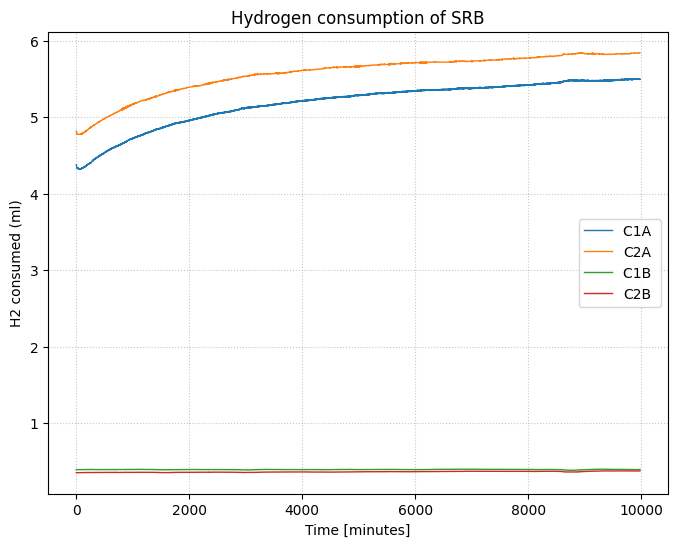

In [13]:
#WITH VOLUME

plt.figure(figsize=(8,6))
plt.plot(time, v1, label="C1A ", linewidth=1)
plt.plot(time, v2, label="C2A", linewidth=1,)
plt.plot(time, v1B, label="C1B ", linewidth=1)
plt.plot(time, v2B, label="C2B", linewidth=1,)
# Labels and legend
plt.xlabel("Time [minutes]")
plt.ylabel("H2 consumed (ml)")
plt.title("Hydrogen consumption of SRB")
plt.legend()
plt.grid(True, linestyle=":", alpha=0.7)

# Show the plot
plt.show()

In [ ]:
output_folder='/Users/adaciortan/Desktop/experiment data/daca ai fii un stick/the column'

name_time = f"2026-01-13_h2-400bar_SRB-time.npy"
name_vol1 = f"2026-01-13_h2-400bar_SRB-volume_1.npy"
name_vol2 = f"volume_2-w.npy"

np.save(os.path.join(output_folder, name_time), time)
np.save(os.path.join(output_folder, name_vol1), df["P1 Vol A"].to_numpy())
np.save(os.path.join(output_folder, name_vol2), df["P2 Vol A"].to_numpy())